In [37]:
# Importing Libraries and dataset

%pip install scikit-learn
%pip install xgboost

# Fix for XGBoost OpenMP error on Mac OSX
import sys
if sys.platform == "darwin":
	# Install libomp using Homebrew if not already installed
	# This will only work if Homebrew is installed on your system
	# If you don't have Homebrew, install it from https://brew.sh/
	import os
	os.system("brew install libomp")

import numpy as np
import pandas as pd

import seaborn as sns
# import plotly.express as px
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip3.12 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
act_runner
chawan
desed
diagram
ghalint
ldcli
mcp-inspector
moodle-dl
mpremote
qrkey
spice-server
==> New Casks
alienator88-sentinel
aloha-browser
font-annotation-mono
font-noto-sans-sunuwar
font-parastoo
font-uoqmunthenkhung
little-snitch@nightly
longbridge-pro
music-presence
textgrabber2
thebrowsercompany-dia
tiny-shield
vibemeter
voicenotes

You have 11 outdated formulae installed.



==> Downloading https://ghcr.io/v2/homebrew/core/libomp/manifests/20.1.7
==> Fetching libomp
==> Downloading https://ghcr.io/v2/homebrew/core/libomp/blobs/sha256:70e6da25205323438aaadfb030b49d439c188ab188cc57e6eff055352395df1d
==> Pouring libomp--20.1.7.arm64_sequoia.bottle.tar.gz
==> Caveats
libomp is keg-only, which means it was not symlinked into /opt/homebrew,
because it can override GCC headers and result in broken builds.

For compilers to find libomp you may need to set:
  export LDFLAGS="-L/opt/homebrew/opt/libomp/lib"
  export CPPFLAGS="-I/opt/homebrew/opt/libomp/include"
==> Summary
🍺  /opt/homebrew/Cellar/libomp/20.1.7: 9 files, 1.7MB
==> Running `brew cleanup libomp`...
Disable this behaviour by setting HOMEBREW_NO_INSTALL_CLEANUP.
Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).


In [112]:
df = pd.read_csv('deliverytime.csv')
df.head(5)

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min)
0,4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24
1,B379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33
2,5D6D,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26
3,7A6A,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21
4,70A2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30


In [113]:
print("The data shape is:", df.shape)
print()
print(df.info())

The data shape is: (45593, 11)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  int64  
 3   Delivery_person_Ratings      45593 non-null  float64
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Type_of_order                45593 non-null  object 
 9   Type_of_vehicle              45593 non-null  object 
 10  Time_taken(min)              45593 non-null  int64  
dtypes: float64(5), int64(2), object(4)
memory usage: 3.8+ MB
None


The Data set does not show any null values

In [114]:
# checking for unique values in Type_of_vehicle and Type_of_order columns
print(np.unique(df.Type_of_vehicle))
print(np.unique(df.Type_of_order))

['bicycle ' 'electric_scooter ' 'motorcycle ' 'scooter ']
['Buffet ' 'Drinks ' 'Meal ' 'Snack ']


There are trailing spaces ' ' after each type, so I will omit them

In [115]:
df['Type_of_vehicle'] = df['Type_of_vehicle'].str.strip()
df['Type_of_order'] = df['Type_of_order'].str.strip()

Becasue these are longtidude and latitude distance information, to calculate the distance betwen two points on a sphere based on their coordinates it is a common practice to use the Haversine formula. 
It estimates the shortest distance between two geographical locations assuming Earth is a perfect sphere. 

In [116]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    # Haversine formula
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of Earth in kilometers
    return c * r

df['distance_km'] = df.apply(
    lambda row: haversine(
        row['Restaurant_latitude'],
        row['Restaurant_longitude'],
        row['Delivery_location_latitude'],
        row['Delivery_location_longitude']
    ), axis=1
)

In [97]:
# Dropping columns irrelevant for training
df.drop(columns=['ID', 'Delivery_person_ID'])

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Type_of_order,Type_of_vehicle,Time_taken(min),distance_km
0,37,4.9,22.745049,75.892471,22.765049,75.912471,Snack,motorcycle,24,3.025149
1,34,4.5,12.913041,77.683237,13.043041,77.813237,Snack,scooter,33,20.183530
2,23,4.4,12.914264,77.678400,12.924264,77.688400,Drinks,motorcycle,26,1.552758
3,38,4.7,11.003669,76.976494,11.053669,77.026494,Buffet,motorcycle,21,7.790401
4,32,4.6,12.972793,80.249982,13.012793,80.289982,Snack,scooter,30,6.210138
...,...,...,...,...,...,...,...,...,...,...
45588,30,4.8,26.902328,75.794257,26.912328,75.804257,Meal,motorcycle,32,1.489846
45589,21,4.6,0.000000,0.000000,0.070000,0.070000,Buffet,motorcycle,36,11.007735
45590,30,4.9,13.022394,80.242439,13.052394,80.272439,Drinks,scooter,16,4.657195
45591,20,4.7,11.001753,76.986241,11.041753,77.026241,Snack,motorcycle,26,6.232393


In [117]:
# Defining the features of the model
features = ['Delivery_person_Age', 'Delivery_person_Ratings', 'distance_km', 'Type_of_order', 'Type_of_vehicle']

In [118]:
# Encoding catagorical values
df_encoded = pd.get_dummies(df[features], drop_first=True)
df_encoded.head(5)

,Delivery_person_Age,Delivery_person_Ratings,distance_km,Type_of_order_Drinks,Type_of_order_Meal,Type_of_order_Snack,Type_of_vehicle_electric_scooter,Type_of_vehicle_motorcycle,Type_of_vehicle_scooter
0,37,4.9,3.025149,False,False,True,False,True,False
1,34,4.5,20.183530,False,False,True,False,False,True
2,23,4.4,1.552758,True,False,False,False,True,False
3,38,4.7,7.790401,False,False,False,False,True,False
4,32,4.6,6.210138,False,False,True,False,False,True


In [119]:
# Preparing the features and the target

X = df_encoded
y = df['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
# Training a simple model

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print("MAE:", mean_absolute_error(y_test, y_pred))
print(f"This means the model, on average, is off by about {mae:.2f} minutes in predicting delivery time")

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print(f"This means the model with an RMSE of {rmse:.2f} is slightly higher than the MAE, indicating the presence of some larger individual errors that the model penalizes more heavily")

r2 = r2_score(y_test, y_pred) * 100
print("R²:", r2_score(y_test, y_pred))
print(f"The model explains {r2:.2f}% of the variability in delivery time — meaning there's still a lot of room for improvement.")

MAE: 6.61027271556845
This means the model, on average, is off by about 6.61 minutes in predicting delivery time
RMSE: 8.361708242333622
This means the model with an RMSE of 8.36 is slightly higher than the MAE, indicating the presence of some larger individual errors that the model penalizes more heavily
R²: 0.20255872970730315
The model explains 20.26% of the variability in delivery time — meaning there's still a lot of room for improvement.


Trying to improve with XGBoost - a more powerful model

In [102]:
# Instantiate the model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

In [103]:
# MAE
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"MAE: {mae_xgb:.2f}")
print(f"This means the model, on average, is off by about {mae_xgb:.2f} minutes in predicting delivery time.")

# RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE: {rmse_xgb:.2f}")
print(f"This means the model with an RMSE of {rmse_xgb:.2f} indicates some larger individual prediction errors.")

# R²
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"R² Score: {r2_xgb:.2f}")
print(f"This means the model explains about {r2_xgb * 100:.1f}% of the variance in delivery time.")


MAE: 5.66
This means the model, on average, is off by about 5.66 minutes in predicting delivery time.
RMSE: 7.20
This means the model with an RMSE of 7.20 indicates some larger individual prediction errors.
R² Score: 0.41
This means the model explains about 40.9% of the variance in delivery time.


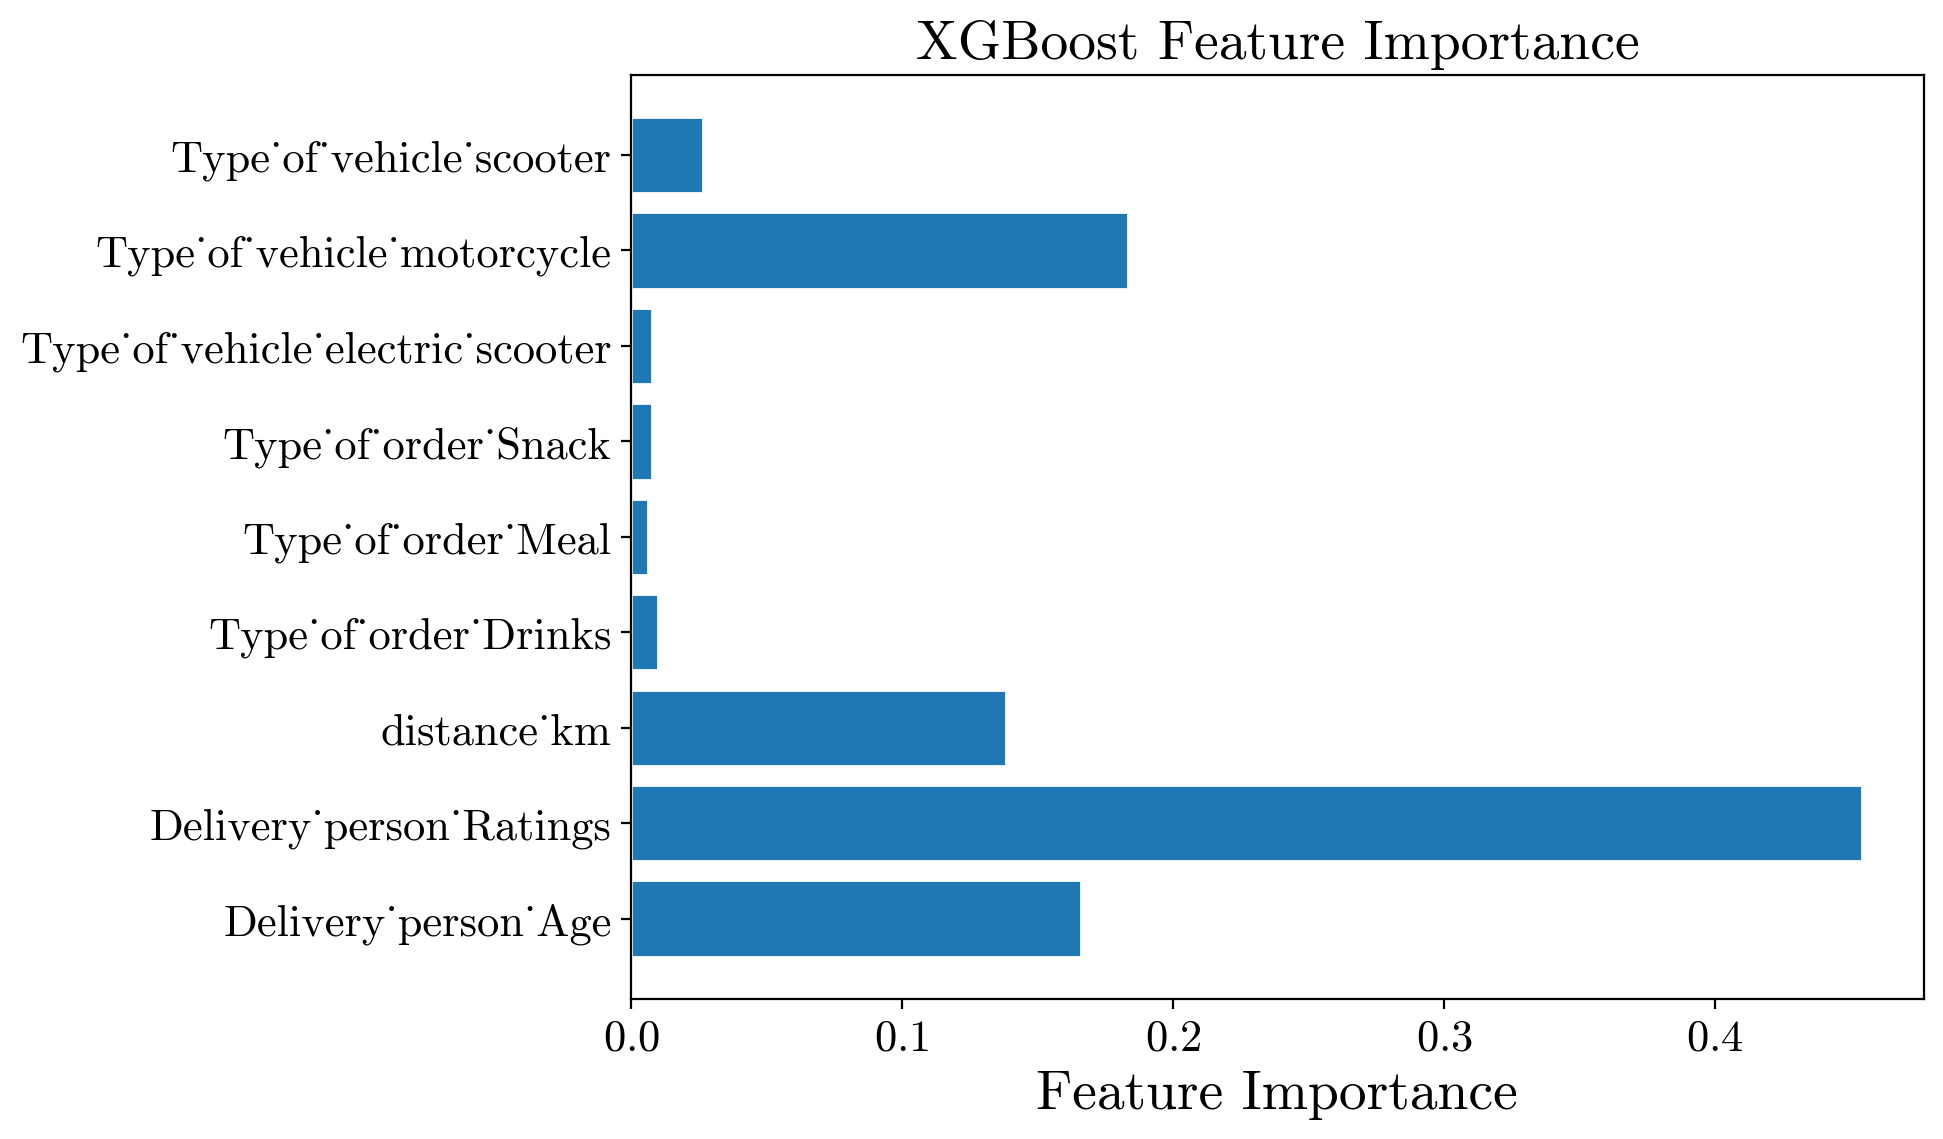

In [104]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Plotting style options
plt.rcdefaults()
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['text.usetex'] = False
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['lines.solid_capstyle'] = 'round'
plt.rcParams['patch.edgecolor'] = 'w'
plt.rcParams['patch.force_edgecolor'] = True
plt.rcParams['font.size'] = 16.0
plt.rcParams['axes.labelsize'] = 20.0
plt.rcParams['axes.titlesize'] = 20.0
plt.rcParams['figure.titlesize'] = 20.0
plt.rcParams['legend.fontsize'] = 16.0
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.sans-serif'] = 'Bitstream Vera Sans'
plt.rcParams['font.family'] = 'cmr10' # Set the font family to use outside mathtext expressions
plt.rcParams['mathtext.fontset'] = 'cm' # Font to use inside mathtext expresions
plt.rcParams["axes.formatter.use_mathtext"] = True # Use mathtext in the ticks of the axes
plt.rcParams["axes.unicode_minus"] = False

xgb.feature_importances_  # Returns importance scores

plt.figure(figsize=(10, 6))
plt.barh(X_train.columns, xgb.feature_importances_)
plt.xlabel("Feature Importance")
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()


Key Takeaways from the XGBoost Feature Importance Plot:

Top Influential Features:
1. Delivery_person_Ratings contributes the most — this suggests that a highly-rated delivery person is often faster or more consistent in delivery time.

2. Type_of_vehicle_motorcycle also plays a big role, implying motorcycles are generally faster.

3. distance_km is expectedly important — longer distances logically require more time.


Moderately Important:

4. Delivery_person_Age has moderate impact — possibly reflecting experience or physical agility.

Low-Impact Features:

5. Categorical features like Type_of_order and other vehicle types (e.g., scooter, electric scooter) have minimal contribution.
They might be correlated with more impactful features (e.g., maybe snacks are usually short-distance).
Or they lack predictive power due to imbalance

## Trying to optimize

Binning ages

In [105]:
# Creating a new binned column
bins = [0, 25, 40, df['Delivery_person_Age'].max()]
labels = ['Young', 'Mid-age', 'Older']

df['Age_group'] = pd.cut(df['Delivery_person_Age'], bins=bins, labels=labels)

In [108]:
# Selecting the columns to keep (dropiing IDs and target)
feature_cols = [
    'Delivery_person_Ratings', 
    'distance_km',
    'Type_of_order', 
    'Type_of_vehicle', 
    'Age_group'
]

# Create a new DataFrame for features
df_features = df[feature_cols]

# One-hot encode categorical variables
df_encoded_2 = pd.get_dummies(df_features, drop_first=True)

# Define target
y = df['Time_taken(min)']

# Final input matrix
X = df_encoded_2


In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [110]:
# Instantiate the model
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

In [111]:
# MAE
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"MAE: {mae_xgb:.2f}")
print(f"This means the model, on average, is off by about {mae_xgb:.2f} minutes in predicting delivery time.")

# RMSE
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE: {rmse_xgb:.2f}")
print(f"This means the model with an RMSE of {rmse_xgb:.2f} indicates some larger individual prediction errors.")

# R²
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"R² Score: {r2_xgb:.2f}")
print(f"This means the model explains about {r2_xgb * 100:.1f}% of the variance in delivery time.")

MAE: 5.91
This means the model, on average, is off by about 5.91 minutes in predicting delivery time.
RMSE: 7.48
This means the model with an RMSE of 7.48 indicates some larger individual prediction errors.
R² Score: 0.36
This means the model explains about 36.2% of the variance in delivery time.


### Trying Random Forest

In [120]:
# Train Random Forest
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"This means the model, on average, is off by about {mae:.2f} minutes in predicting delivery time.")

print(f"RMSE: {rmse:.2f}")
print(f"This means the model with an RMSE of {rmse:.2f} indicates some larger individual prediction errors.")

print(f"R² Score: {r2:.2f}")
print(f"This means the model explains about {r2 * 100:.1f}% of the variance in delivery time.")

MAE: 5.67
This means the model, on average, is off by about 5.67 minutes in predicting delivery time.
RMSE: 7.21
This means the model with an RMSE of 7.21 indicates some larger individual prediction errors.
R² Score: 0.41
This means the model explains about 40.7% of the variance in delivery time.
